# Импорт 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Код из предоставленных материалов

In [3]:
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

In [4]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


In [5]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [6]:
def to_polynom(x, order = 1, add_bias = False):
#     print(x)
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]
#     print(x)
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
#     print(out)
    return out.reshape(-1, x.size).T



In [7]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)  


In [8]:
class LassoRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
    
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term
                  
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)

In [9]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

In [10]:
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);
    plt.tight_layout()


In [11]:
def vis_weigths(weights):
    numbers = np.arange(0,len(weights))
    tick_labels = ['w'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels );

In [12]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);

# Задание №1. Синтетический набор данных

## Первый набор данных

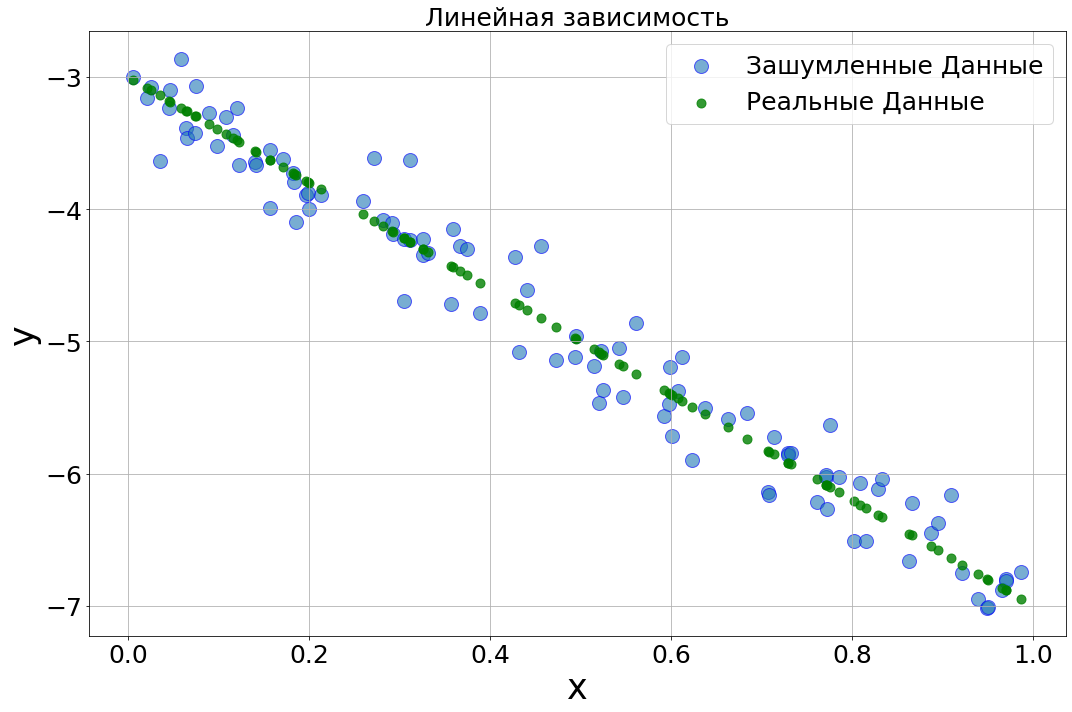

In [13]:
#Зашумленные линейные данные
noise_power = 0.25

y_lin, y_true_lin, x_lin = dataset(a = -4, b = -3,
                       f = None,  N = 100,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y_lin, y_true_lin,x_lin, 'Линейная зависимость')

## Второй набор данных

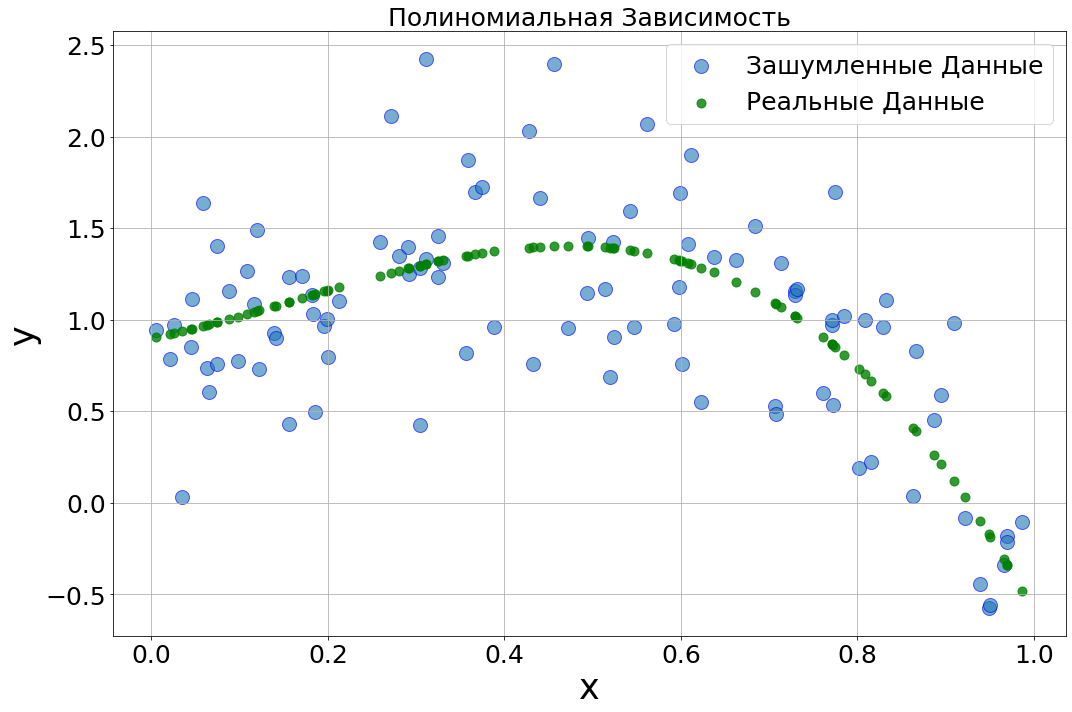

In [14]:
#Создадим нелинейные данные с тремя параметрами
noise_power = 0.455

y_3, y_true_3, x_3 = dataset(a = [1,2.5,-5], b = 0.9,
                       f = None,  N = 100,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y_3, y_true_3,x_3, 'Полиномиальная Зависимость')

## Третий набор данных

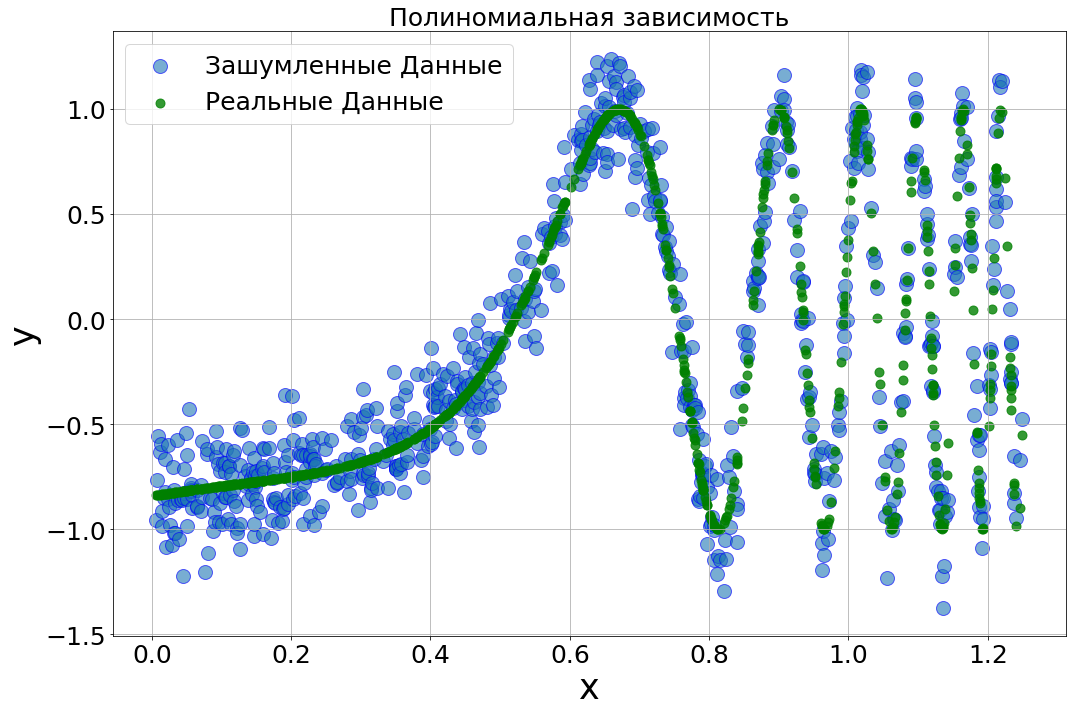

In [15]:
#Добавим еще больше a и функцию синуса.
noise_power = 0.15

y_sin, y_true_sin, x_sin = dataset(a = [1,-2,3,4,8], b = -1,
                       f = np.sin,  N = 800,
                       x_max =1.25, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y_sin, y_true_sin,x_sin, 'Полиномиальная зависимость')

# 1.2

## Полиномальные данные

Test Score = 0.52, Train Score = 0.41


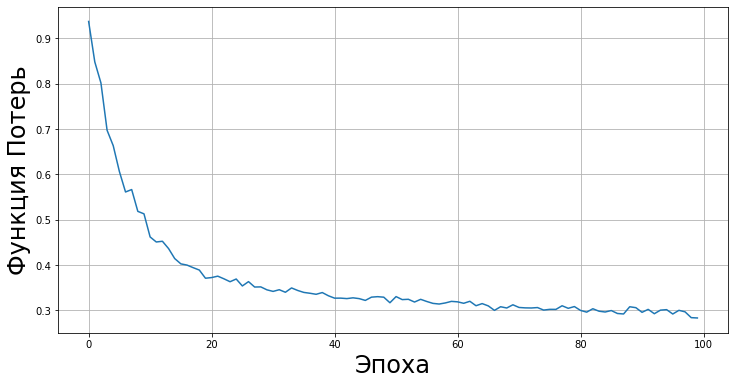

In [16]:
x_train_3, y_train_3,  x_test_3, y_test_3 = train_test_split(x_3, y_3,  test_size=0.3, )

order  = 5

x_train__3 = to_polynom(x_train_3, order=order)
x_test__3 = to_polynom(x_test_3,  order=order)


pd.DataFrame(x_train__3).tail(4)

regr_harm_poly_3 = LinearRegression(learning_rate=0.05,
                        epochs=100,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_3.fit(x_train__3, y_train_3)
print(f'Test Score = {regr_harm_poly_3.score(x_test__3, y_test_3):.2f}, Train Score = {regr_harm_poly_3.score(x_train__3, y_train_3):.2f}')
regr_harm_poly_3.plot_cost()

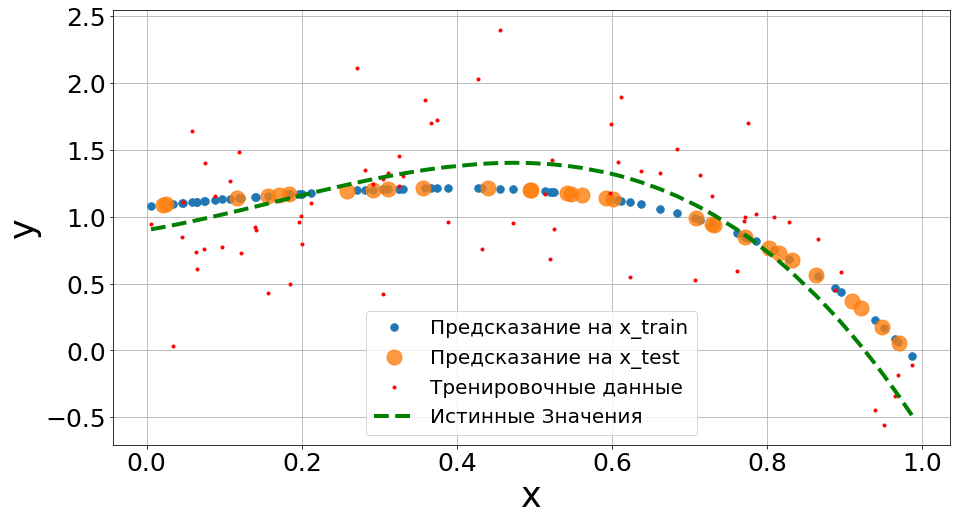

In [17]:
plt.figure(figsize=(15,8))

plot_model_class(x_train__3, y_train_3, x_test__3, x_3, y_true_3, regr_harm_poly_3)

Данные оказались сложными для нашей регрессии. Попоробуем улучшить результат с помощью регуляризации.

### Применяем эластичную регуляризацию

Test Score = 0.52, Train Score = 0.41


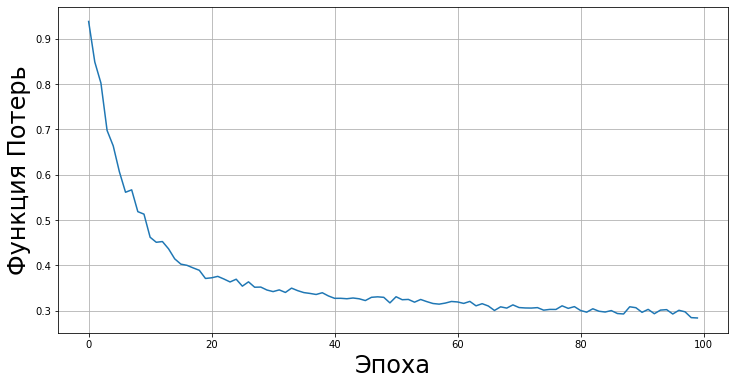

In [18]:
regr_l1l2_3 = ElasticRegression(learning_rate=0.05,
                         epochs=100,batch_size=25,
                         l1_penalty = 0.0001,l2_penalty = 0.0005)
regr_l1l2_3.fit(x_train__3, y_train_3)

print(f'Test Score = {regr_l1l2_3.score(x_test__3, y_test_3):.2f}, Train Score = {regr_l1l2_3.score(x_train__3, y_train_3):.2f}')
regr_l1l2_3.plot_cost()
plt.show()

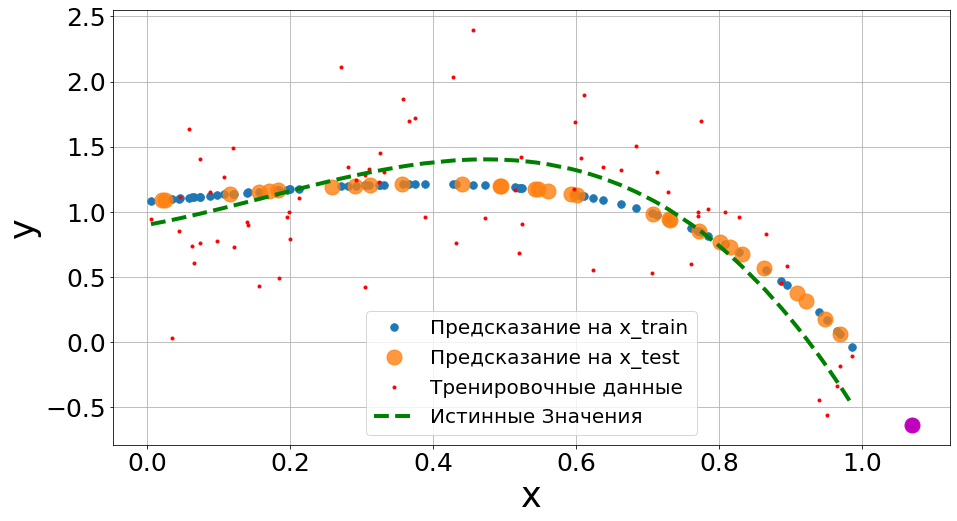

In [19]:
plt.figure(figsize=(15,8))

plot_model_class(x_train__3, y_train_3, x_test__3, x_3, y_true_3, regr_l1l2_3)

plt.plot([1.07], 
         regr_l1l2_3.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

Изменив значения l1 и l2 не удалось повысить качество модели. Вероятно, более важными будут другие параметры.

## Гармонические данные

In [20]:
x_train_sin, y_train_sin,  x_test_sin, y_test_sin = train_test_split(x_sin, y_sin,  test_size=0.3, )    


order  = 9

x_train__sin = to_polynom(x_train_sin, order=order)
x_test__sin  = to_polynom(x_test_sin,  order=order)


pd.DataFrame(x_train__sin).tail(4)

,0,1,2,3,4,5,6,7,8
556,0.309664,0.095892,0.029694,9.195205e-03,2.847421e-03,8.817432e-04,2.730439e-04,8.455179e-05,2.618262e-05
557,1.070612,1.146211,1.227147,1.313799e+00,1.406569e+00,1.505890e+00,1.612225e+00,1.726068e+00,1.847949e+00
558,0.971434,0.943683,0.916726,8.905382e-01,8.650988e-01,8.403861e-01,8.163793e-01,7.930583e-01,7.704035e-01
559,0.018181,0.000331,0.000006,1.092584e-07,1.986409e-09,3.611458e-11,6.565931e-13,1.193741e-14,2.170320e-16


Test Score = 0.26, Train Score = 0.25


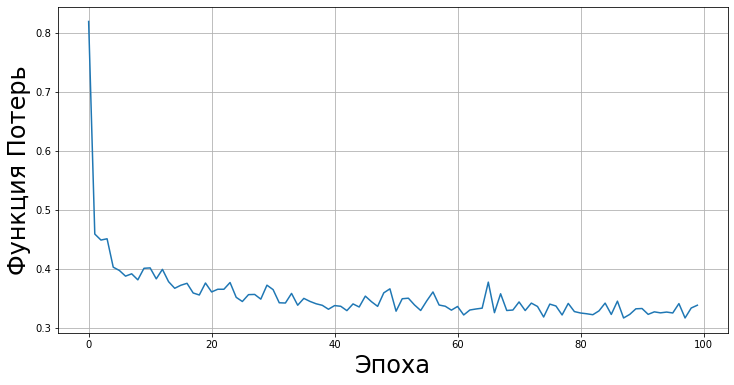

In [21]:
regr_harm_poly_sin = LinearRegression(learning_rate=0.05,
                        epochs=100,batch_size=40,
                        n_batches=None
                        )

regr_harm_poly_sin.fit(x_train__sin, y_train_sin)
print(f'Test Score = {regr_harm_poly_sin.score(x_test__sin, y_test_sin):.2f}, Train Score = {regr_harm_poly_sin.score(x_train__sin, y_train_sin):.2f}')
regr_harm_poly_sin.plot_cost()

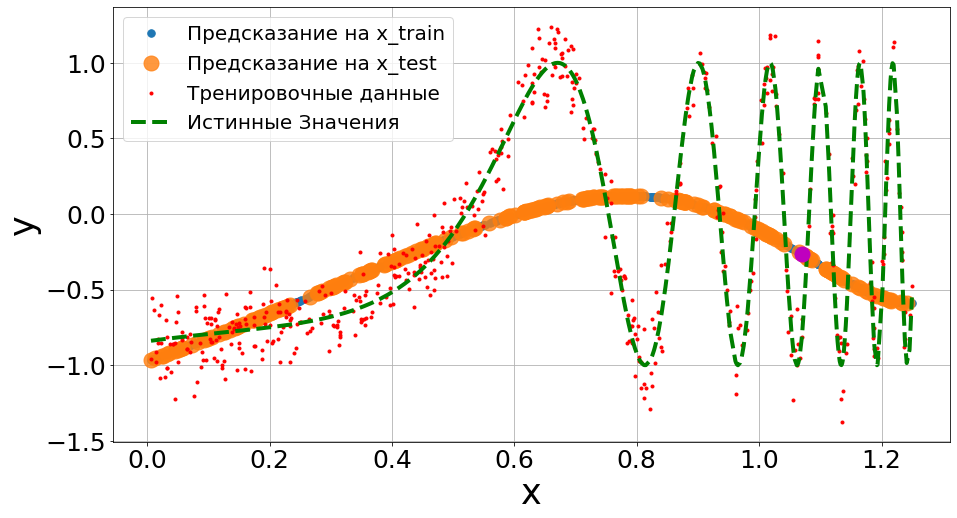

In [22]:
plt.figure(figsize=(15,8))

plot_model_class(x_train__sin, y_train_sin, x_test__sin, x_sin, y_true_sin, regr_harm_poly_sin)



plt.plot([1.07], 
         regr_harm_poly_sin.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

Модель стала справляться все хуже. Хотя и был увеличен полином и применена функция синуса, но 0.26 низкий результат. Попробуем l1 регуляризацию.

## L2 регуляризация

Test Score = 0.26, Train Score = 0.25


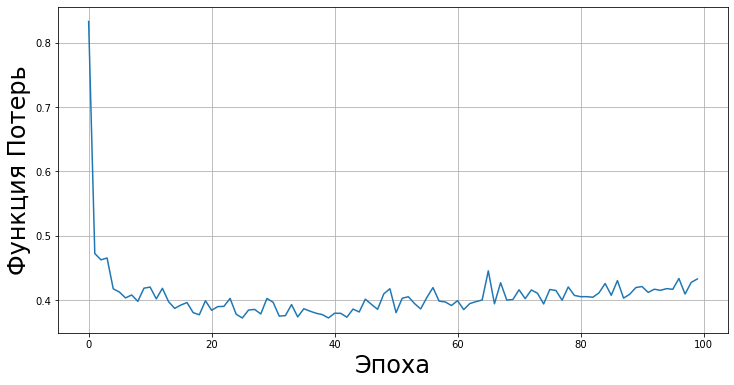

In [23]:
regr_l2_sin = RidgeRegression(learning_rate=0.05,
                       epochs=100,batch_size=40,
                       l2_penalty = 0.05)
regr_l2_sin.fit(x_train__sin, y_train_sin)

print(f'Test Score = {regr_l2_sin.score(x_test__sin, y_test_sin):.2f}, Train Score = {regr_l2_sin.score(x_train__sin, y_train_sin):.2f}')
regr_l2_sin.plot_cost()

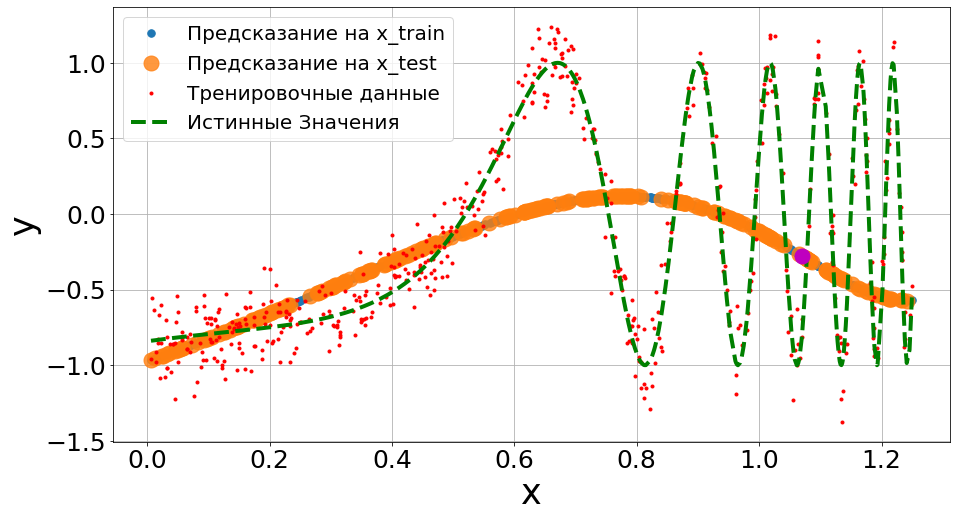

In [24]:
plt.figure(figsize=(15,8))

plot_model_class(x_train__sin, y_train_sin, x_test__sin, x_sin, y_true_sin, regr_l2_sin)

plt.plot([1.07], 
         regr_l2_sin.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

Я изменял и степень полинома, и разные коэффициенты пробовал, но добиться повышения аккуратности не получилось. Видимо данные слишком сложные.

# Задание 2. Car Moldova

In [25]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year','Distance_per_price']

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('my_file.csv', delimiter = ',')

df_num = data[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train1)
X_train1 = scaler.transform(X_train1) 
X_test1  = scaler.transform(X_test1) 
df_num.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  int64  
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
 4   km_year               32220 non-null  float64
 5   Distance_per_price    32220 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.5 MB


,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Distance_per_price
0,2011,195000.0,1800.0,7750.0,17727.272727,25.161290
1,2014,135000.0,1500.0,8550.0,16875.000000,15.789474
2,2012,110000.0,1500.0,6550.0,11000.000000,16.793893
3,2006,200000.0,1600.0,4100.0,12500.000000,48.780488
4,2000,300000.0,2200.0,3490.0,13636.363636,85.959885


Test Score = 0.48, Train Score = 0.49


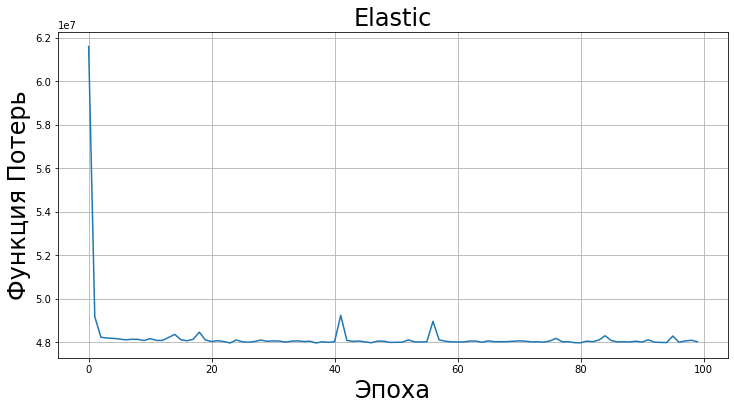

In [27]:
#Возьмем модель из 1.2, которую обучали на третьих данных

regr_l1l2 = ElasticRegression(learning_rate=0.05,
                         epochs=100,batch_size=25,
                         l1_penalty = 0.0001,l2_penalty = 0.0005)
regr_l1l2.fit(X_train1,y_train1)

print(f'Test Score = {regr_l1l2.score(X_test1, y_test1):.2f}, Train Score = {regr_l1l2.score(X_train1, y_train1):.2f}')
regr_l1l2.plot_cost(title='Elastic')


Попробуем изменить test score с помощью разного преобразования данных.

## 2.2

### Стандартизация

In [28]:
data = pd.read_csv('standartization.csv', delimiter = ',')

df_num = data[num_columns].copy()

df_num.head()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 
df_num.head()

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Distance_per_price
0,0.376492,0.128983,-0.112516,-0.179081,17727.272727,25.161290
1,0.793761,-0.490816,-0.604496,-0.095044,16875.000000,15.789474
2,0.515582,-0.749065,-0.604496,-0.305136,11000.000000,16.793893
3,-0.318957,0.180633,-0.440503,-0.562500,12500.000000,48.780488
4,-1.153495,1.213632,0.543457,-0.626578,13636.363636,85.959885


train R2: 0.4897; test R2: 0.4770


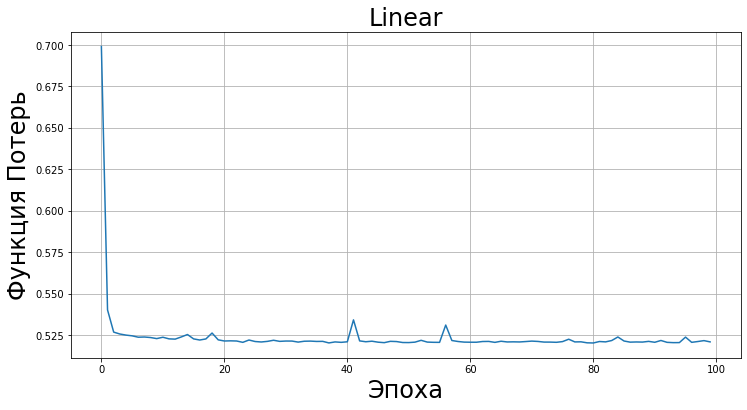

In [29]:
regr = LinearRegression(learning_rate=0.05,
                        epochs=100,batch_size=25)

regr.fit(X_train, y_train)

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))
regr.plot_cost(title='Linear')

Test Score = 0.4763, Train Score = 0.4872


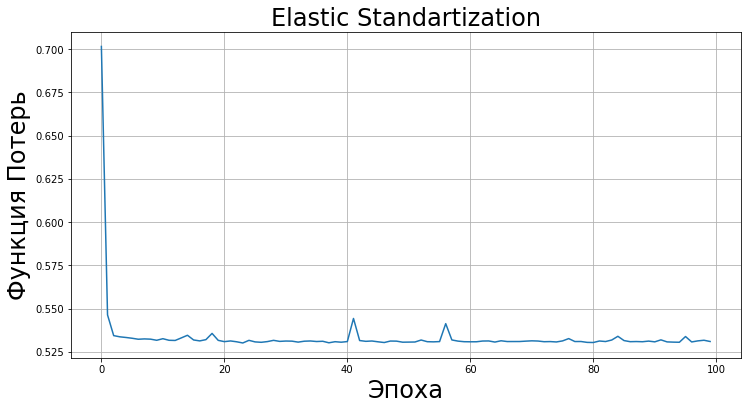

In [30]:
regr_l1l2_st = ElasticRegression(learning_rate=0.05,
                         epochs=100,batch_size=25,
                         l1_penalty = 0.0001,l2_penalty = 0.0005)
regr_l1l2_st.fit(X_train, y_train)

print(f'Test Score = {regr_l1l2_st.score(X_test, y_test):.4f}, Train Score = {regr_l1l2_st.score(X_train, y_train):.4f}')
regr_l1l2_st.plot_cost(title='Elastic Standartization')


Результаты стали чуть хуже. Стандартизация не дала заметного улучшения работа способности. 

### Нормализация

In [31]:
data = pd.read_csv('normalization.csv', delimiter = ',')

df_num = data[num_columns].copy()

df_num.head()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 
df_num.head()

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Distance_per_price
0,0.80,0.194919,0.333333,0.075651,17727.272727,25.161290
1,0.86,0.134913,0.270833,0.083667,16875.000000,15.789474
2,0.82,0.109911,0.270833,0.063627,11000.000000,16.793893
3,0.70,0.199920,0.291667,0.039078,12500.000000,48.780488
4,0.58,0.299930,0.416667,0.032966,13636.363636,85.959885


train R2: 0.4897; test R2: 0.4770


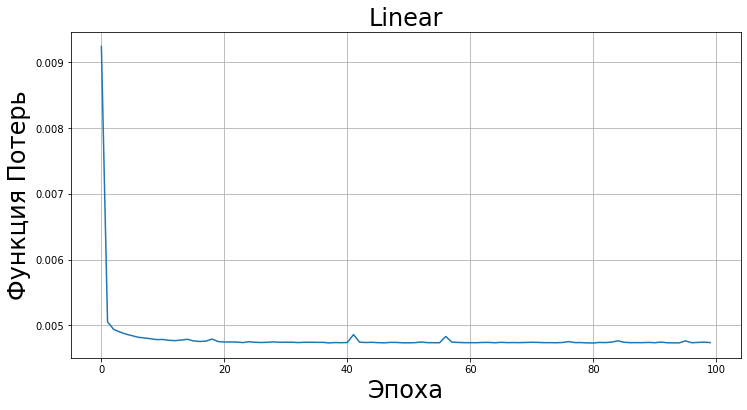

In [32]:
regr = LinearRegression(learning_rate=0.05,
                        epochs=100,batch_size=25)

regr.fit(X_train, y_train)

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))
regr.plot_cost(title='Linear')

Test Score = 0.4763, Train Score = 0.4867


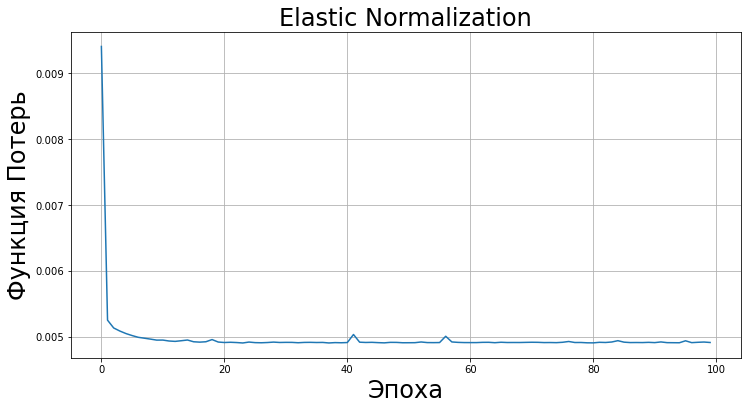

In [33]:
regr_l1l2_norm = ElasticRegression(learning_rate=0.05,
                         epochs=100,batch_size=25,
                         l1_penalty = 0.0001,l2_penalty = 0.0005)
regr_l1l2_norm.fit(X_train, y_train)

print(f'Test Score = {regr_l1l2_norm.score(X_test, y_test):.4f}, Train Score = {regr_l1l2_norm.score(X_train, y_train):.4f}')
regr_l1l2_norm.plot_cost(title='Elastic Normalization')


### Логарифм


In [34]:
data = pd.read_csv('log.csv', delimiter = ',')

df_num = data[num_columns].copy()

df_num.head()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 
df_num.head()

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Distance_per_price
0,7.606387,12.180755,7.495542,8.955448,17727.272727,25.161290
1,7.607878,11.813030,7.313220,9.053687,16875.000000,15.789474
2,7.606885,11.608236,7.313220,8.787220,11000.000000,16.793893
3,7.603898,12.206073,7.377759,8.318742,12500.000000,48.780488
4,7.600902,12.611538,7.696213,8.157657,13636.363636,85.959885


train R2: 0.6994; test R2: 0.6882


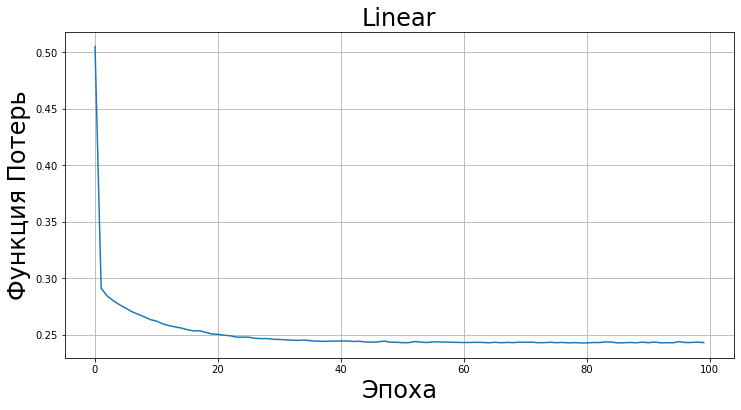

In [35]:
regr = LinearRegression(learning_rate=0.05,
                        epochs=100,batch_size=25)

regr.fit(X_train, y_train)

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))
regr.plot_cost(title='Linear')

Test Score = 0.6870, Train Score = 0.6978


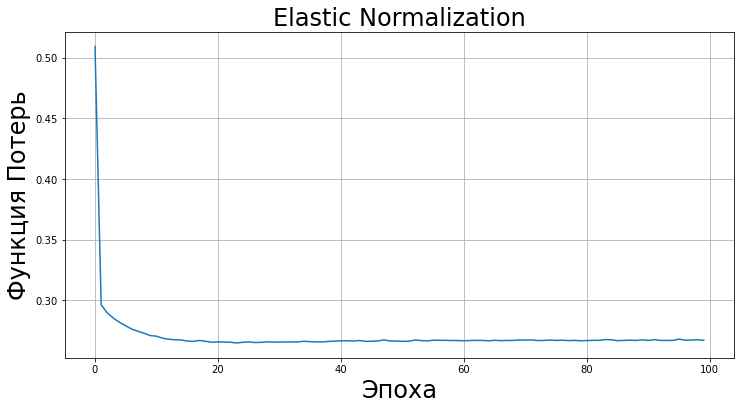

In [36]:
regr_l1l2_log = ElasticRegression(learning_rate=0.05,
                         epochs=100,batch_size=25,
                         l1_penalty = 0.0001,l2_penalty = 0.0005)
regr_l1l2_log.fit(X_train, y_train)

print(f'Test Score = {regr_l1l2_log.score(X_test, y_test):.4f}, Train Score = {regr_l1l2_log.score(X_train, y_train):.4f}')
regr_l1l2_log.plot_cost(title='Elastic Normalization')


Логарифмическая обработка данных сильно повысила точность модели. Однако моя регуляризация сделала хуже. Можно поизменять параметры и попытаться добиться улучшения.

## 2.3

### Добавление one-hot

In [37]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year','Distance_per_price','Cheap','Affordable','Luxury']

In [38]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
data = pd.read_csv('for_one_hot_encoding.csv', delimiter = ',')
data.head()

,Unnamed: 0,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,Mileage,Distance_per_price,Car_Status
0,0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,1,7750.0,11,17727.272727,со средним пробегом,25.161290,Affordable
1,1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,0,8550.0,8,16875.000000,со средним пробегом,15.789474,Affordable
2,2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,0,6550.0,10,11000.000000,со средним пробегом,16.793893,Affordable
3,3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,0,4100.0,16,12500.000000,со средним пробегом,48.780488,Affordable
4,4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,0,3490.0,22,13636.363636,со средним пробегом,85.959885,Cheap


In [39]:
one_hot = data.copy()
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(data[['Car_Status']])
one_hot = one_hot.assign(Affordable = [i[0] for i in ohe.fit_transform(data[['Car_Status']])], Cheap = [i[1] for i in ohe.fit_transform(data[['Car_Status']])],
              Luxury = [i[2] for i in ohe.fit_transform(data[['Car_Status']])])
one_hot.head(10)

,Unnamed: 0,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,Mileage,Distance_per_price,Car_Status,Affordable,Cheap,Luxury
0,0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,1,7750.0,11,17727.272727,со средним пробегом,25.161290,Affordable,1.0,0.0,0.0
1,1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,0,8550.0,8,16875.000000,со средним пробегом,15.789474,Affordable,1.0,0.0,0.0
2,2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,0,6550.0,10,11000.000000,со средним пробегом,16.793893,Affordable,1.0,0.0,0.0
3,3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,0,4100.0,16,12500.000000,со средним пробегом,48.780488,Affordable,1.0,0.0,0.0
4,4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,0,3490.0,22,13636.363636,со средним пробегом,85.959885,Cheap,0.0,1.0,0.0
5,5,Volkswagen,Passat,2010,Universal,290000.0,1390.0,Petrol,0,5600.0,12,24166.666667,с большим пробегом,51.785714,Affordable,1.0,0.0,0.0
6,6,Volkswagen,Touareg,2010,SUV,220000.0,2400.0,Diesel,1,17000.0,12,18333.333333,со средним пробегом,12.941176,Luxury,0.0,0.0,1.0
7,7,Mercedes,Series (W124),1991,Sedan,240000.0,2300.0,Petrol,0,2850.0,31,7741.935484,с небольшим пробегом,84.210526,Cheap,0.0,1.0,0.0
8,8,BMW,5 Series,2004,Sedan,325000.0,300.0,Diesel,0,3400.0,18,18055.555556,со средним пробегом,95.588235,Cheap,0.0,1.0,0.0
9,9,Mercedes,E Class,2010,Sedan,210000.0,2200.0,Diesel,1,11400.0,12,17500.000000,со средним пробегом,18.421053,Affordable,1.0,0.0,0.0


In [40]:
df_num = one_hot[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 
df_num.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  int64  
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
 4   km_year               32220 non-null  float64
 5   Distance_per_price    32220 non-null  float64
 6   Cheap                 32220 non-null  float64
 7   Affordable            32220 non-null  float64
 8   Luxury                32220 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.2 MB


,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,Distance_per_price,Cheap,Affordable,Luxury
0,2011,195000.0,1800.0,7750.0,17727.272727,25.161290,0.0,1.0,0.0
1,2014,135000.0,1500.0,8550.0,16875.000000,15.789474,0.0,1.0,0.0
2,2012,110000.0,1500.0,6550.0,11000.000000,16.793893,0.0,1.0,0.0
3,2006,200000.0,1600.0,4100.0,12500.000000,48.780488,0.0,1.0,0.0
4,2000,300000.0,2200.0,3490.0,13636.363636,85.959885,1.0,0.0,0.0


train R2: 0.6412; test R2: 0.6454


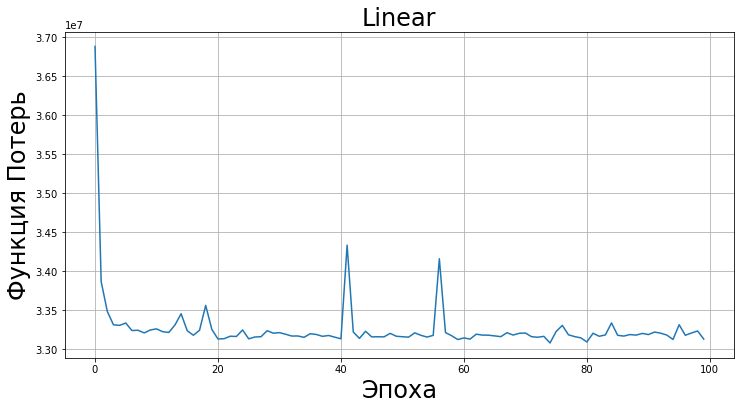

In [41]:
regr = LinearRegression(learning_rate=0.05,
                        epochs=100,batch_size=25)

regr.fit(X_train, y_train)

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))
regr.plot_cost(title='Linear')

Test Score = 0.6455, Train Score = 0.6411


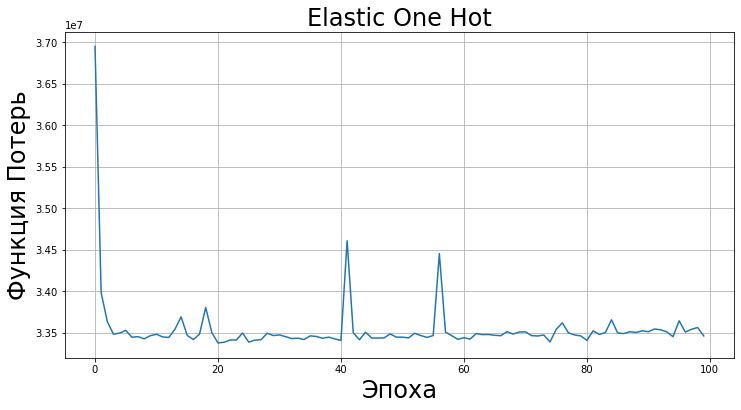

In [42]:
regr_l1l2_one_hot = ElasticRegression(learning_rate=0.05,
                         epochs=100,batch_size=25,
                         l1_penalty = 0.0001,l2_penalty = 0.0005)
regr_l1l2_one_hot.fit(X_train, y_train)

print(f'Test Score = {regr_l1l2_one_hot.score(X_test, y_test):.4f}, Train Score = {regr_l1l2_one_hot.score(X_train, y_train):.4f}')
regr_l1l2_one_hot.plot_cost(title='Elastic One Hot')


Заметно улучшение после добавление признаков на 0.16, что весомо. Также чуть-чуть регуляризация повысила точность.

## 2.4

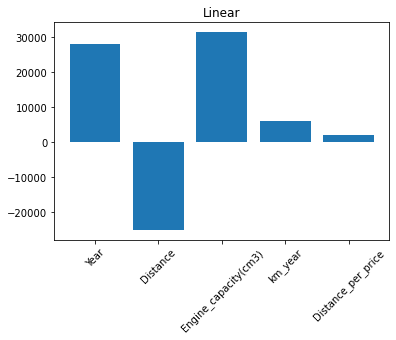

In [43]:
w, b = regr_l1l2.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),['Year', 'Distance', 'Engine_capacity(cm3)', 'km_year','Distance_per_price'], rotation = 45 )
plt.title('Linear')
plt.show()

Наш новый признак имеет слабый положительный вес на точность функции.

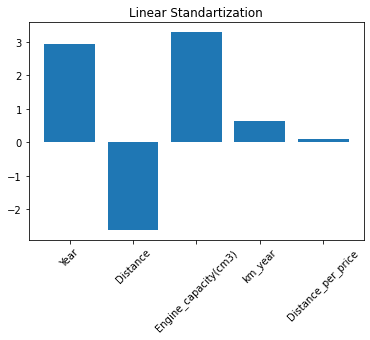

In [44]:
w, b = regr_l1l2_st.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),['Year', 'Distance', 'Engine_capacity(cm3)', 'km_year','Distance_per_price'], rotation = 45 )
plt.title('Linear Standartization')
plt.show()

Веса не изменились по влиянию. Изменилась шкала.

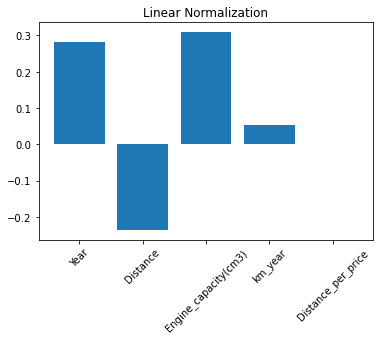

In [45]:
w, b = regr_l1l2_norm.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),['Year', 'Distance', 'Engine_capacity(cm3)', 'km_year','Distance_per_price'], rotation = 45 )
plt.title('Linear Normalization')
plt.show()

Нормализация также как стандартизация оставила прежними веса и изменила шкалу. Мою колонку не видно из-за слишком маленьких значений.

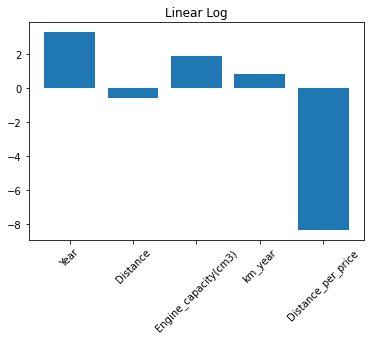

In [46]:
w, b = regr_l1l2_log.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),['Year', 'Distance', 'Engine_capacity(cm3)', 'km_year','Distance_per_price'], rotation = 45 )
plt.title('Linear Log')
plt.show()

Логарифм значительно улучшил точность модели и значения мною придуманного признака стали определяющими.

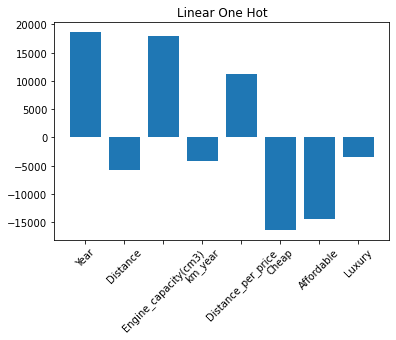

In [47]:
w, b = regr_l1l2_one_hot.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 )
plt.title('Linear One Hot')
plt.show()

Новые признаки на основе one hot сделали модель точнее и как видно их веса сильно влияют. Более того это повлияло на важность придуманной метрки Distance per price.